![](img/seattle.png)

# Projet P4: Anticipez les besoins en consommation électrique de bâtiments
**(Partie 1 - Traitement des données, Exploration)**




**Il s´agit de prédire la consommation d´energie et les niveaux d´émissions de gaz à effet de serre de bâtiments. Ces prédictions se baseront sur des mesures déjà effectuées sur d´autres bâtiments.**  

Dans un premier temps, on rassemble les données disponibles. Après une exploration et un prétraitement, elles sont sauvegardées pour être utilisées dans le second notebook.

In [1]:
## Outil de visualisation a installer 
## pip install missingno 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mso
plt.style.use('seaborn-whitegrid')

## Présentation des informations disponibles

On utilise les fichiers de 2015 et 2016 pour alimenter les modèles. Les deux fichiers sont fusionnés dans un même jeu de donnée.

In [3]:
mon_fichier_csv_2015 = 'donnee/2015-building-energy-benchmarking.csv'
mon_fichier_csv_2016 = 'donnee/2016-building-energy-benchmarking.csv'

In [4]:
data_2015 = pd.read_csv( mon_fichier_csv_2015)
data_2016 = pd.read_csv( mon_fichier_csv_2016)

**Les lignes et colonnes des deux fichiers:**  
On regarde les parties communes et parties spécifiques entre les fichiers

In [5]:
## dimension du jeu de donnée 2015 (lignes,colonnes)
data_2015.shape

(3340, 47)

In [6]:
## dimension du jeu de donnée 2015 (lignes,colonnes)
data_2016.shape

(3376, 46)

-  **Nombre de lignes: chaque ligne correspond à un bâtiment**

Chaque ligne correspond à un bâtiment.  
'OSEBuildingID' est une variable unique par ligne, elle désigne un bâtiment.  

In [7]:
## nombre de batiments dans le fichier de 2015 : 3340
len(data_2015['OSEBuildingID'].unique()) 

3340

In [8]:
## nombre de batiments dans le fichier de 2016 : 3376
len(data_2016['OSEBuildingID'].unique()) 

3376

In [9]:
## nombre de batiments dans les deux jeux de données : 3432
data = pd.concat([data_2015,data_2016])
len(data['OSEBuildingID'].unique()) ## 3432 batiments differents

3432

Le nombre de bâtiments communs et spécifiques à chaque fichier

In [10]:
## batiments communs : 3284 batiments communs entre les deux fichiers
intersection = set(data_2015['OSEBuildingID'].unique()).intersection(set(data_2016['OSEBuildingID'].unique()))
len(intersection)

3284

In [11]:
## batiments spécifiques à 2015 : 56 batiments
len(data_2015['OSEBuildingID'].unique())- len(intersection)

56

In [12]:
## batiments spécifiques à 2016 : 92 batiments
len(data_2016['OSEBuildingID'].unique())- len(intersection)

92

-  **Nombre de colonnes:  chaque colonne correspond à une caractéristique de bâtiment**  

Colonnes communes et spécifiques

In [13]:
## Colonnes communes : 41
intersection_colonne = set(data_2015.columns.to_list()).intersection(set(data_2016.columns.to_list()))
len(intersection_colonne)

37

**Fusion des deux fichiers**

In [14]:
## Renommage de colonnes pour le jeu de 2015
## Avant de concatener on renomme certaines colonnes du fichier de 2015, 
## le nom differe un peu de celles de 2016 
## mais elles correspondent a la meme caracteristique.

data_2015 = data_2015.rename(columns={"Zip Codes": "ZipCode", 
                          "GHGEmissions(MetricTonsCO2e)": "TotalGHGEmissions",
                          "GHGEmissionsIntensity(kgCO2e/ft2)": "GHGEmissionsIntensity",
                          "Comment": "Comments",
                          }).copy();

In [15]:
## donnee 2015: recuperation du zipcode depuis la colonne 'location'
## On recupere le 'zipcode', 
## Cela permet d´avoir un niveau de maillage plus fin pour tester les modeles
for index in range(len(data_2015)):
    dico = eval(data_2015.loc[index,'Location'])
    data_2015.loc[index,'ZipCode'] = int( eval(dico['human_address'])['zip'] )

In [16]:
## Fusion des deux jeux de données avec le jeu de 2015 renommé
data = pd.concat([data_2015,data_2016])

In [17]:
## Colonnes commune entre 2015 et 2016
intersection_colonne = set(data_2015.columns.to_list()).intersection(set(data_2016.columns.to_list()))
## Colonnes specifiques 2015
col_specifique_2015 = set(data_2015.columns.to_list())-intersection_colonne
print('2015: ',col_specifique_2015,'\n')
## Colonnes specifiques 2016
col_specifique_2016 = set(data_2016.columns.to_list())-intersection_colonne
print('2016: ',col_specifique_2016)

2015:  {'City Council Districts', 'SPD Beats', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'Location', 'OtherFuelUse(kBtu)'} 

2016:  {'Latitude', 'Longitude', 'Address', 'State', 'City'}


**Dans le jeu de données concaténé, on va filtrer les lignes et les colonnes** 

Pour les lignes, on conserve: 
  - les batiments uniquements presents en 2015,
  - les batiments uniquements presents en 2016,
  - pour les batiments communs entre les deux années:
    -  on ne conserve que la derniere année (2016)
    -  on ne conserve que les bâtiments de 2015 qui ont eu une evolution tres importante en terme d´emission polluantes ( ex: travaux de renovation, utilisation differente du batiment).   

On ne prendra pas en compte dans l´etude : 
  - les bâtiments à usage non residentiel
  - les hopitaux 
 
Pour les colonnes, on effectue un premier tri sur les variables qui semblent interessantes.



**Filtre sur les lignes (bâtiments)**

In [18]:
## Etude des emissions d´une année à l´autre pour les batiments communs.
## Pour cela, on calcule l´ecart relatif des emissions de CO2 entre 2015 et 2016
ecart = []
colonne = 'TotalGHGEmissions'
for batiments_id in list(intersection):
    
    valeur_emission_ref = data[ data['OSEBuildingID'] == batiments_id ] [colonne].iloc[0] ##2015
    ecart_emissions = data[ data['OSEBuildingID'] == batiments_id ] [colonne].diff().iloc[1] ## ecart 2016-2015
    
    if  valeur_emission_ref != 0:
        ecart_relatif =  ecart_emissions/valeur_emission_ref ## (2016-2015) / (2015)
        ecart.append(ecart_relatif)
    else:
        ecart.append(np.nan)
df_ecart =  pd.DataFrame(ecart,columns=['Ecart emissions'])   
df_ecart['OSEBuildingID'] = intersection

On conserve les bâtiments du jeu de 2015 ayant un écart d´emissions important (entre 20% et 100%) d´une année à l´autre

In [19]:
## Ecart relatif des emissions entre 2015 et 2016, entre 20% et 100%.
## on considerera un batiment dont les emissions ont une evolution importante entre 2015 et 2016
## comme deux batiments disctincts pour alimenter les modeles
masque = (np.abs(df_ecart['Ecart emissions'])<0.2) | (np.abs(df_ecart['Ecart emissions'])>1)

In [20]:
masque_building_2015 = (data['DataYear'] == 2015) \
& (data['OSEBuildingID'].isin(df_ecart[masque]['OSEBuildingID'].to_list()))

In [21]:
data = data[~masque_building_2015].copy()

On conserve les bâtiments du jeu de 2016 ayant un écart d´emissions de moins de 100 % d´une année sur l´autre

In [22]:
masque = np.abs(df_ecart['Ecart emissions'])<1
masque_building_2016 = (data['DataYear'] == 2016) \
& (data['OSEBuildingID'].isin(df_ecart[masque]['OSEBuildingID'].to_list()))

In [23]:
data = data[masque_building_2016].copy()

On conserve les bâtiments considérés comme non résidentiels.

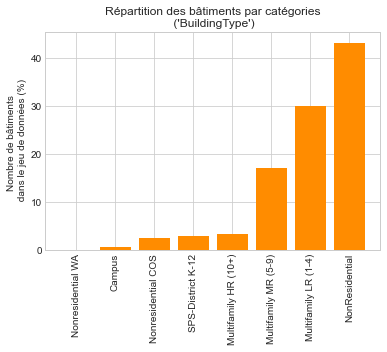

In [24]:
## Graphique repartition par categories BuildingType
proportion = 100/data_2016.shape[0]
var_categorie = data_2016['BuildingType'].value_counts(ascending=True)*proportion
plt.bar(range(len(var_categorie)),var_categorie,color="darkorange")
plt.xticks(range(len((var_categorie))),var_categorie.index,rotation=90);
plt.title('Répartition des bâtiments par catégories\n (\'BuildingType\')')
plt.ylabel('Nombre de bâtiments \n dans le jeu de données (%)')
plt.rcParams.update({'font.size': 12})

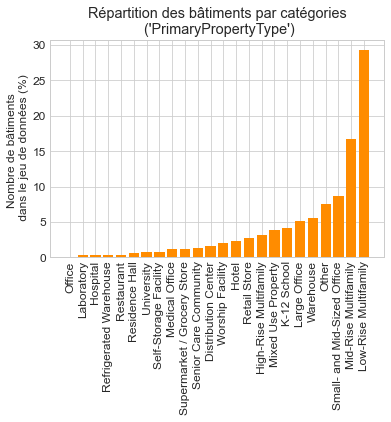

In [25]:
## Graphique repartition par categories PrimaryPropertyType
proportion = 100/data_2016.shape[0]
var_categorie = data_2016['PrimaryPropertyType'].value_counts(ascending=True)*proportion
plt.bar(range(len(var_categorie)),var_categorie,color="darkorange")
plt.xticks(range(len((var_categorie))),var_categorie.index,rotation=90);
plt.title('Répartition des bâtiments par catégories\n (\'PrimaryPropertyType\')')
plt.ylabel('Nombre de bâtiments \n dans le jeu de données (%)')
plt.rcParams.update({'font.size': 12})

On enleve les bâtiments categorisés comme "Multifamily" pour ne garder que ceux à usage non résidentiels

In [26]:
## Filtrage sur les batiments non residentiels pour la categorie BuildingType
masque_family = data['BuildingType'].str.contains('Multifamily')
data = data[~masque_family].copy()

print( " {} batiments enlevés".format(masque_family.sum()))

 1642 batiments enlevés


In [27]:
## Meme demarche pour la categorie PrimaryPropertyType
masque_family =  data['PrimaryPropertyType'].str.contains('Multifamily')
data = data[~masque_family].copy()

print( " {} batiments enlevés".format(masque_family.sum()))

 2 batiments enlevés


In [28]:
## Filtrage sur les batiments non residentiels pour la categorie PrimaryPropertyType
masque_family =  data_2016['PrimaryPropertyType'].str.contains('Multifamily')
data_graph = data_2016[~masque_family].copy()

print( " {} batiments enlevés".format(masque_family.sum()))

 1656 batiments enlevés


In [29]:
## Filtrage sur les batiments non residentiels pour la categorie BuildingType
masque_family = data_graph['BuildingType'].str.contains('Multifamily')
data_graph = data_graph[~masque_family].copy()

print( " {} batiments enlevés".format(masque_family.sum()))

 55 batiments enlevés


**Filtre sur les colonnes (caractéristiques d´un bâtiment)**  

In [30]:
## Les thematiques interessantes à conserver:
## emissions de CO2 eq, consommation d´energie, 
## surface, usage du batiment, date de construction, lieu
##
## (il suffit de commenter une ligne de la liste pour ne pas la prendre en compte)

liste_colonne =\
[##'OSEBuildingID',
 ##'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 ##'PropertyName',
 ##'TaxParcelIdentificationNumber',
 ##'Location',
 'CouncilDistrictCode', 
 'Neighborhood',
 'YearBuilt',
 ##'NumberofBuildings',
 ##'NumberofFloors',
 ##'PropertyGFATotal',
 ##'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 ##'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 ##'SecondLargestPropertyUseType',
 ##'SecondLargestPropertyUseTypeGFA',
 ##'ThirdLargestPropertyUseType',
 ##'ThirdLargestPropertyUseTypeGFA',
 ##'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 ##'SiteEUIWN(kBtu/sf)',
 ##'SourceEUI(kBtu/sf)',
 ##'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 ##'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 ##'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 ##'OtherFuelUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 ##'DefaultData',
 ##'Comments',
 ##'ComplianceStatus',
 ##'Outlier',
 ##'2010 Census Tracts',
 ##'Seattle Police Department Micro Community Policing Plan Areas',
 ##'City Council Districts',
 ##'SPD Beats',
 'ZipCode',
 ##'Address',
 ##'City',
 ##'State',
 ##'Latitude',
 ##'Longitude'
]

In [31]:
data = data[liste_colonne].copy()

**Transformation des variables**  
On réalise des conversions en unités SI, et le renommage des quartiers de la colonne 'Neighborhood'

-  Conversion des unités  
   - sf en m2  
   - kBtu en kW  
   - kBtu/sf en kW/m2  

In [32]:
## Conversion d´unité anglo-saxonne en unité SI
## 1 BTU = 1 055,06 joules
## 1 ft = 0,3048 m 
## https://fr.wikipedia.org/wiki/Conversion_des_unit%C3%A9s

conversion_kBtu_vers_kWh = (data['Electricity(kWh)']/data['Electricity(kBtu)']).mean()
conversion_kBtu_par_sft_vers_kWh_par_m2 = conversion_kBtu_vers_kWh / (0.3048)**2 
conversion_sf_vers_m2 = 0.3048**2

In [33]:
def conversion_colonne(data,unite,unite_si,conversion):
    '''
    Conversion des unites des colonnes
    '''
    
    ## on recupere les colonnes terminant par le mot unite
    liste_colonne = data.columns.to_list()
    cols = [ a for a in liste_colonne if (a.find(unite)!=-1) ] 
    
    ## on applique la conversion
    for col in cols:
        data[col+unite_si] = data[col]*conversion
        data.drop(columns=[col], inplace=True)
    
    return data   

In [34]:
## Conversion en unité SI
unite = '(kBtu)'
unite_si = '_(kWh)'
conversion = conversion_kBtu_vers_kWh
data = conversion_colonne(data,unite,unite_si,conversion)

unite = '(kBtu/sf)'
unite_si = '_(kWh/m2)'
conversion = conversion_kBtu_par_sft_vers_kWh_par_m2
data = conversion_colonne(data,unite,unite_si,conversion)

unite = 'GFA'
unite_si = '_(m2)'
conversion = conversion_sf_vers_m2
data = conversion_colonne(data,unite,unite_si,conversion)

data['GHGEmissionsIntensity_(m2)'] =  data['GHGEmissionsIntensity']/(conversion_sf_vers_m2)
data.drop(columns = ['GHGEmissionsIntensity'], inplace=True)
data.drop(columns=['Electricity(kWh)'],inplace=True)

-  Renommage des quartiers de la colonne Neighborhood   
Modification des noms de quartiers pour avoir une cohérence des majuscules/minuscules

In [35]:
quartier_list = data['Neighborhood'].str.capitalize().unique()

In [36]:
for quartier in quartier_list:
    filtre = data['Neighborhood'].str.capitalize().isin([quartier])
    data.loc[filtre,'Neighborhood'] = quartier

In [37]:
data['CouncilDistrictCode'] = data['CouncilDistrictCode'].astype('object')
data['ZipCode'] = data['ZipCode'].astype('object')

## Exploration

### Les lieux

Il y a differents niveaux de maillage géographique (CouncilDistrictCode, Neighborhood, ZipCode).  
On peut s´apercevoir qu´ils sont un peu entremelés.  

In [38]:
pd.crosstab(data['CouncilDistrictCode'],data['Neighborhood'])

Neighborhood,Ballard,Central,Delridge,Downtown,East,Greater duwamish,Lake union,Magnolia / queen anne,North,Northeast,Northwest,Southeast,Southwest
CouncilDistrictCode,,,,,,,,,,,,,
1,0,0,45,0,0,29,0,0,0,0,0,0,39
2,0,0,0,41,1,298,0,0,0,0,0,41,0
3,0,48,0,10,110,3,14,0,0,1,0,4,0
4,0,0,0,0,0,0,46,0,2,107,0,0,0
5,0,0,0,0,0,0,0,0,60,4,61,0,0
6,67,0,0,0,0,0,21,0,0,0,23,0,0
7,0,0,0,296,7,0,59,143,0,0,0,0,0


In [39]:
pd.crosstab(data['CouncilDistrictCode'],data['ZipCode'])

ZipCode,98006.0,98011.0,98013.0,98020.0,98033.0,98053.0,98070.0,98101.0,98102.0,98103.0,...,98146.0,98154.0,98155.0,98164.0,98165.0,98168.0,98177.0,98178.0,98191.0,98199.0
CouncilDistrictCode,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,1,0,1,...,2,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,1,...,0,0,1,0,0,1,0,3,0,2
3,0,0,0,0,0,0,0,9,10,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,16,23,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0,0,0,6,...,0,0,2,0,1,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,1,0,0,130,0,0,...,0,2,0,1,0,0,0,0,1,20


### Les  niveaux d´émissions de CO2 eq et de consommation d´énergie

Les hopitaux sont très emissifs, on ne les prendra pas en compte dans l´étude. Il s´agit de bâtiments que l´on construit peu souvent.

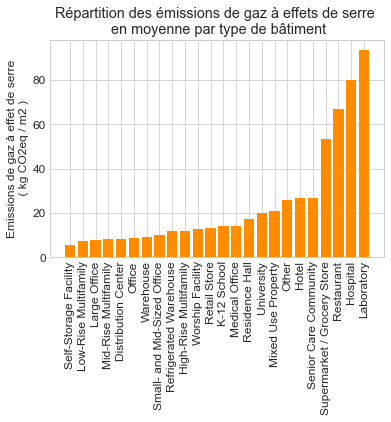

In [40]:
## Graphique emissions de gaz a effets de serre en une année par type de batiments en moyenne
colonne = 'GHGEmissionsIntensity' ## k CO2eq / sf
data_graph = data_2016
var_emissions = data_graph.groupby(by='PrimaryPropertyType').mean()[colonne].sort_values(ascending=True)

var_categorie = var_emissions/conversion_sf_vers_m2
plt.bar(range(len(var_categorie)),var_categorie,color="darkorange")
plt.xticks(range(len((var_categorie))),var_categorie.index,rotation=90);
plt.title('Répartition des émissions de gaz à effets de serre \n en moyenne par type de bâtiment')
plt.ylabel('Emissions de gaz à effet de serre\n ( kg CO2eq / m2 )')
plt.rcParams.update({'font.size': 12})

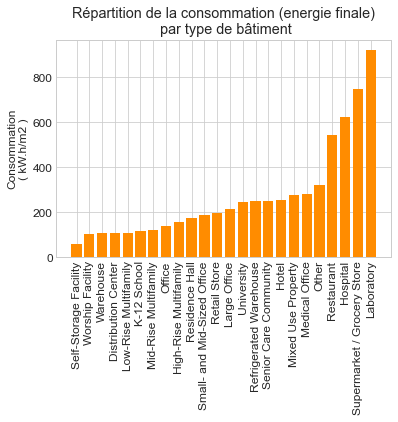

In [41]:
##Répartition de la consommation (energie finale)
colonne = 'SiteEUI(kBtu/sf)'

var_emissions = data_graph.groupby(by='PrimaryPropertyType').mean()[colonne].sort_values(ascending=True)

var_categorie = var_emissions*conversion_kBtu_par_sft_vers_kWh_par_m2

plt.bar(range(len(var_categorie)),var_categorie,color="darkorange")
plt.xticks(range(len((var_categorie))),var_categorie.index,rotation=90);
plt.title('Répartition de la consommation (energie finale)\n par type de bâtiment')
plt.ylabel('Consommation\n( kW.h/m2 )')
plt.rcParams.update({'font.size': 12})

In [42]:
## On enleve les hopitaux. C´est un type de bâtiment qui n´est que rarement construit.
data = data[~data['PrimaryPropertyType'].str.contains('Hospital')].copy()

In [43]:
## On enleve les buildings avec une consommation d´energie nulle (mal renseignée ?)
data = data[data['SiteEnergyUse(kBtu)_(kWh)']!=0].copy()

### Nature et proportion d´energie consommée

**Création des variables**  
On crée trois variables supplémentaires: nature et proportion d´energie consommée (électricité,gaz,vapeur)

In [44]:
## Calcul par type d´energie de la contribution a l´energie totale consommée 
data['Electricity_p100'] = 100*data['Electricity(kBtu)_(kWh)']/data['SiteEnergyUse(kBtu)_(kWh)']
data['NaturalGas_p100'] = 100*data['NaturalGas(kBtu)_(kWh)']/data['SiteEnergyUse(kBtu)_(kWh)']
data['SteamUse_p100'] = 100*data['SteamUse(kBtu)_(kWh)']/data['SiteEnergyUse(kBtu)_(kWh)']
data['Nature_energie_p100'] = data['Electricity_p100'] + data['NaturalGas_p100'] + data['SteamUse_p100'] 

In [45]:
## On enleve les buildings dont la somme des proportions d´energie ne donnent pas environ 100 % 
masque = (data['Nature_energie_p100']>95) & (data['Nature_energie_p100']<105)
print(data['Nature_energie_p100'].shape)
data = data[masque]
print(data['Nature_energie_p100'].shape) 

(1560,)
(1547,)


In [46]:
## electricite et gaz ont un ecart type identique
## 70% electricité et 30% gaz en moyenne
data[['Electricity_p100','NaturalGas_p100','SteamUse_p100', 'Nature_energie_p100' ]].describe()

,Electricity_p100,NaturalGas_p100,SteamUse_p100,Nature_energie_p100
count,1547.000000,1547.000000,1547.000000,1547.000000
mean,70.171811,27.831846,1.991121,99.994777
std,26.352717,26.458662,8.888621,0.137899
min,0.000000,0.000000,0.000000,96.243872
25%,48.969710,0.000000,0.000000,99.999982
50%,71.017542,24.106525,0.000000,99.999991
75%,99.999797,49.449083,0.000000,100.000000
max,100.001129,100.000000,76.698738,101.297834


In [47]:
## On enleve les colonnes des energie consommées pour ne garder que les proportions d´energie
data = data.drop(columns=['Electricity(kBtu)_(kWh)', 'NaturalGas(kBtu)_(kWh)', 'SteamUse(kBtu)_(kWh)', 'Nature_energie_p100'])

La consommation d´énergie et les émissions de CO2eq sont liés.  
Elles dépendent egalement des types et proportion d´energie utilisée. 
Pour une même consommation d´énergie, plus la part d´électricité est importante, plus les émissions sont faibles.

In [48]:
import seaborn as sns

In [49]:
data['Part d´électricité'] = pd.cut(data['Electricity_p100'],
                                                    5,
                                                    labels=['[0-20%]','[20-40%]','[40-60%]','[60-80%]','[80-100%]'])

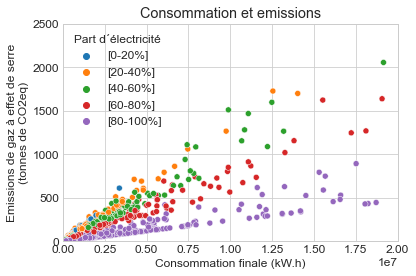

In [50]:
import seaborn as sns 
sns.scatterplot(x='SiteEnergyUse(kBtu)_(kWh)',y='TotalGHGEmissions',
                 data=data,hue=data['Part d´électricité'],legend='full');

plt.axis([0,2e7,0,2500]);
plt.xlabel('Consommation finale (kW.h)')
plt.ylabel('Emissions de gaz à effet de serre\n(tonnes de CO2eq)')
plt.title('Consommation et emissions')
data.drop(columns=['Part d´électricité'],inplace=True)

### Représentation graphique des entrées.

In [51]:
## X : données numerique et categorielle
## y : donnée de sortie numerique

X_num = data.loc[:,data.dtypes!='object'] ## float ou int
X_num = X_num.drop(columns = ['TotalGHGEmissions','SiteEnergyUse(kBtu)_(kWh)']).copy()
X_cat = data.iloc[:,np.array(data.dtypes=='object')] ## object
y_emissions = data['TotalGHGEmissions']
y_conso = data['SiteEnergyUse(kBtu)_(kWh)']

In [52]:
X_cat.shape ## 6 variables catégorielles

(1547, 6)

In [53]:
X_num.shape ## 9 variables numériques

(1547, 9)

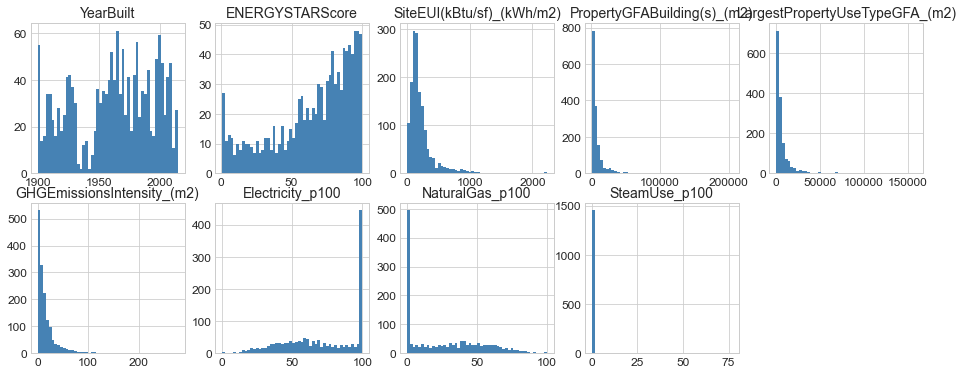

In [54]:
## histogrammes des variables numeriques
X=X_num
fig = plt.figure(figsize=(16, 16))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(5,5, (feat_idx+1))
    h = ax.hist(X.iloc[:, feat_idx], bins=50, color='steelblue', edgecolor='none')
    ax.set_title(X.columns[feat_idx], fontsize=14)

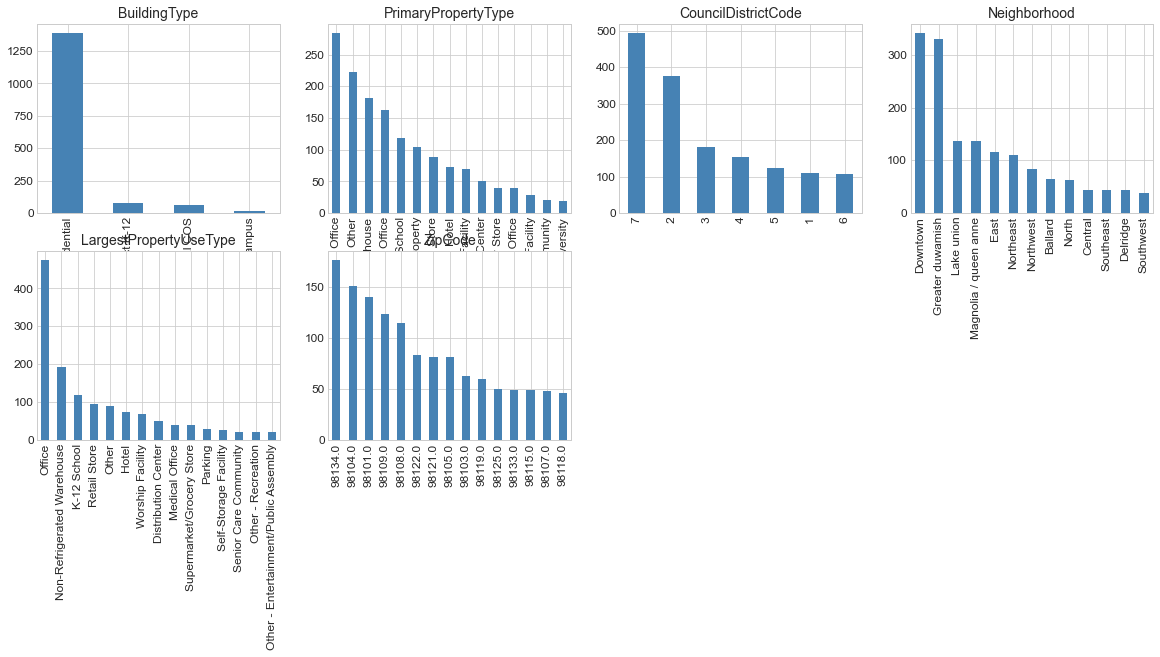

In [55]:
## histogramme des variables categorielles
X= X_cat.copy()
fig = plt.figure(figsize=(20, 16))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(4,4, (feat_idx+1))
    X.iloc[:, feat_idx].value_counts().iloc[:15].plot(kind="bar",color='steelblue', edgecolor='none')
    ax.set_title(X.columns[feat_idx], fontsize=14)


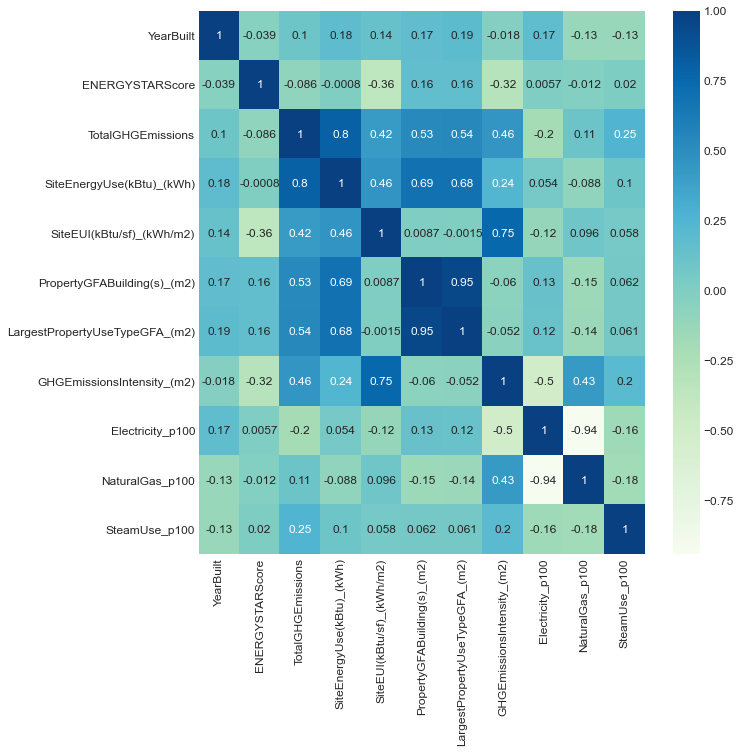

In [56]:
## On regarde les correlations, pour savoir si on garde toutes les variables.
import seaborn as sns
corr_var =data.corr()

fig = plt.figure(figsize=(10, 10))
sns.heatmap(corr_var, cmap = 'GnBu',annot=True);

-  Consommation d´electricite et de gaz sont anti correlées  
-  Emissions et consommation sont liées  
-  Consommation et surface augmente dans la meme direction
-  Pas de correlation saillante entre les autres variables, sauf sur les surfaces

On effectue un second tri sur les colonnes

In [57]:
variables = [ ## variables à enlever
 ##'BuildingType',
 ##'PrimaryPropertyType',
 ##'CouncilDistrictCode', ## apres calcul, on ne garde que le maillage le plus grand.
 'Neighborhood',
 ##'YearBuilt',
 'LargestPropertyUseType', ## apres calcul, on ne garde qu´un seul type.
 ##'ENERGYSTARScore',
 ##'TotalGHGEmissions',
 'ZipCode',
 ##'SiteEnergyUse(kBtu)_(kWh)',
 'LargestPropertyUseTypeGFA_(m2)',
 'GHGEmissionsIntensity_(m2)',
 ##'Electricity_p100',
 ##'NaturalGas_p100',
 ##'SteamUse_p100',
 'SiteEUI(kBtu/sf)_(kWh/m2)'
]

In [58]:
data.drop(columns=variables,inplace=True)

In [59]:
## les variables finalement conservées
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1547 entries, 0 to 3321
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BuildingType                 1547 non-null   object 
 1   PrimaryPropertyType          1547 non-null   object 
 2   CouncilDistrictCode          1547 non-null   object 
 3   YearBuilt                    1547 non-null   int64  
 4   ENERGYSTARScore              1038 non-null   float64
 5   TotalGHGEmissions            1547 non-null   float64
 6   SiteEnergyUse(kBtu)_(kWh)    1547 non-null   float64
 7   PropertyGFABuilding(s)_(m2)  1547 non-null   float64
 8   Electricity_p100             1547 non-null   float64
 9   NaturalGas_p100              1547 non-null   float64
 10  SteamUse_p100                1547 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 145.0+ KB


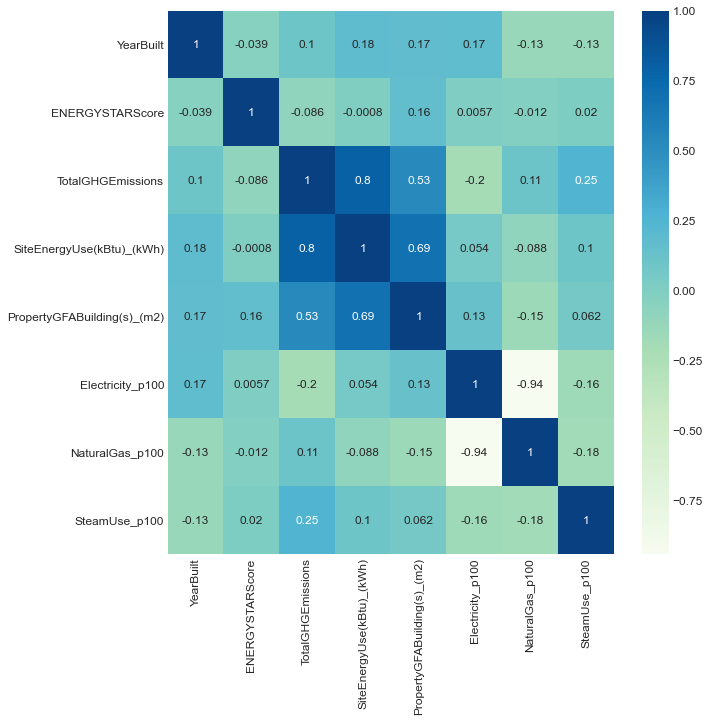

In [60]:
corr_var =data.corr()

fig = plt.figure(figsize=(10, 10))
sns.heatmap(corr_var, cmap = 'GnBu',annot=True);

## Enregistrement des données

In [61]:
mon_fichier = 'donnee/building_energy_benchmarking_pretraitement.csv'
data.to_csv(mon_fichier,index=False)

In [62]:
## Apres traitement on a un jeu de donnée avec ~1500 lignes et 11 colonnes
data.shape

(1547, 11)

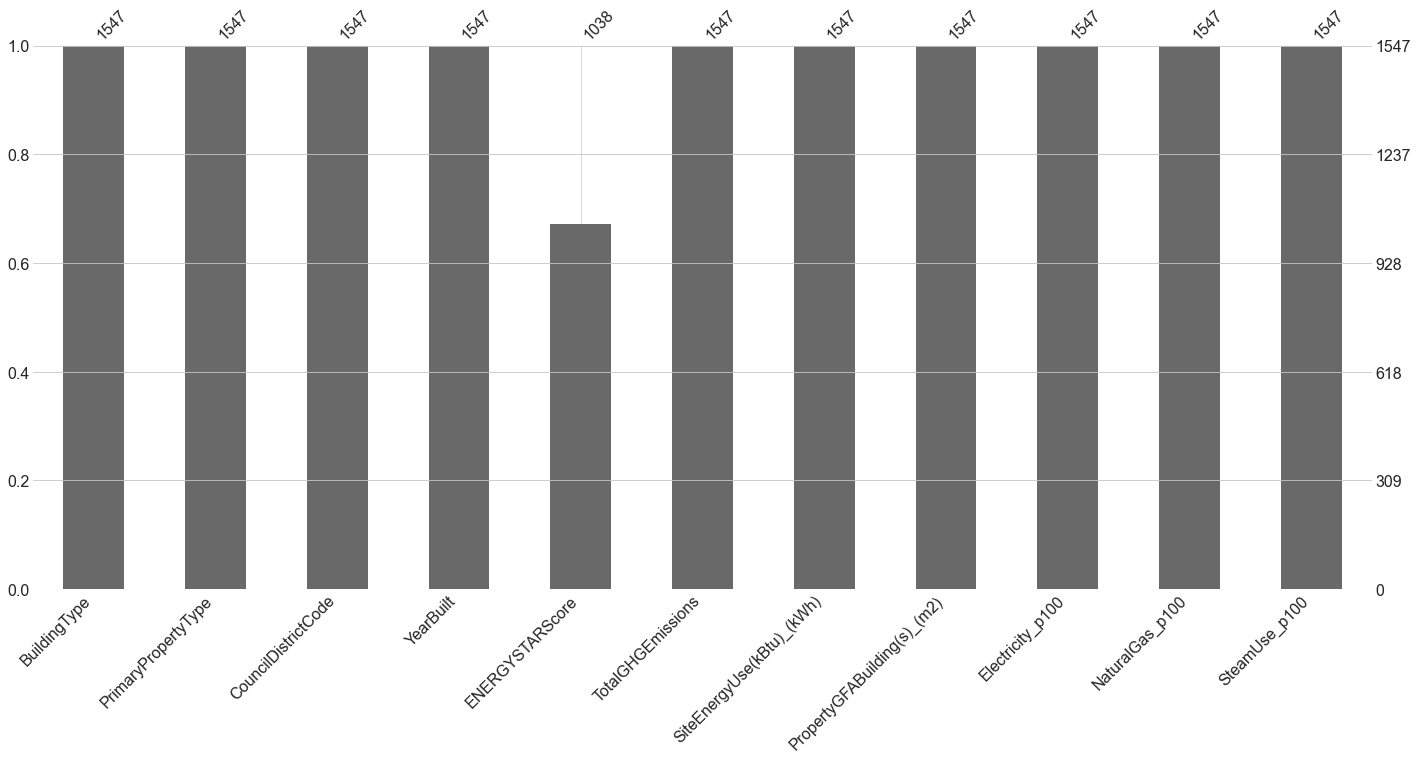

In [63]:
## Representation des valeurs manquantes.
mso.bar(data);

Il y a des variables numériques et catégorielles.  
Les domaines de variation des variables numériques sont tres différents, il conviendra de les ramener à un même domaine de variation. Les variables catégorielles seront encodées pour pouvoir être utilisées par les modèles. Cela sera effectué dans le second notebook pour la partie calcul.